Notes from James

take function that exists for tone power optimization
and incorporate into a notebook
get tests going

	something that says heres S21, takes inputs (one comb?, parameter, function that does algotrithm) and return
	
	keep model model of KID different from simulation of Sweep (probably dont need to modify sweep)
	
	sweep + kid model that can plug and play + tone optimization
	all three should be plyug a dn play
	
	don't build a new algorithm or kid model, make sure you get tests running!!! start TESTS
	
	
->> Keep 1 idea per function, general lowest level idea.
		if 10 lines are doing high_pass filter, make one line and call it high_pas filter, and they can refer.
		No global namespac
		

In [1]:
# Building Symmetry function


def sym_test(freqs, amps):
    """Symmetry scoring function
    freqs: frequency array of S21 data
    amps: Amplitude array of S21 data (absolutes)

    returns sym_score between 0,1
    """

    centre = np.argmin(amps) 
    #print(centre)

    asym = 0
    #print(len(freqs))
    #print(range(len(freqs) - centre))
    for i in range(len(freqs) - centre):
        asym = amps[centre + i] - amps[centre - i]
        asym += asym
    
    sym_score = asym
    return np.abs(sym_score)

def sym_test1(freqs, amps):
    """Symmetry scoring function
    freqs: frequency array of S21 data
    amps: Amplitude array of S21 data (absolutes)

    returns sym_score between 0,1
    """

    def remove_side(arr, s):
        if s < 0:
            return arr[-s:]
        elif s > 0:
            return arr[:-s]
        else:
            return arr
    
    centre = np.argmin(amps) 
    difference = 2*centre + 1
    
    asym = remove_side(amps - np.abs(np.roll(np.flip(amps), difference)), len(amps) - difference)
    if len(asym) < 2: 
        print('disproportionate')
        return
    
    sym_score = asym.sum()
    return sym_score

In [2]:
import numba
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt


In [3]:
# Current VNA Model
def modelLoopbackSweep(freqs=None, fi=350e6, ff=850e6, amp_max=300e5, N=500000):
    # just modelling magnitude for now... not sure how to do complex
    if type(freqs) == np.ndarray:
        fi = np.min(freqs)
        ff = np.max(freqs)
        N = np.size(freqs)
    else:
        freqs = np.linspace(fi, ff, N)
    def model(x, fi, ff, amp_max, n=20, slope=0.1):
        # n is fall-off factor
        a = -(fi + ff)/2
        g = (ff - fi)/2
        z = (x + a)/g
        return amp_max*(-z**n - slope*(z + 1) + 1)
    
    def add_gaussian_noise(data, std_dev, mean=0):
        noise = np.random.normal(mean, std_dev, size=data.shape)
        noisy_data = data + noise
        return noisy_data
    
    
    S21 = model(freqs, fi, ff, amp_max)
    # S21 = S21 + modelKid(freqs, P=np.ones_like(freqs)*300e4, f0=600e6, Es=6000, Qr=10000, Qc=30000, yi=0.6, A=amp_max)
    #S21 = add_gaussian_noise(S21, std_dev=amp_max/1e3)
    
    S21[S21<0] = 0 # we don't want neg. values
    
    return freqs, S21


def show_loop():
    freqs, S21m_loopback = modelLoopbackSweep()
    print(sym_test(freqs, S21m_loopback))

    plt.plot(freqs, S21m_loopback)
    #plot.set_xlim()
    plt.show()

4775.82715557201


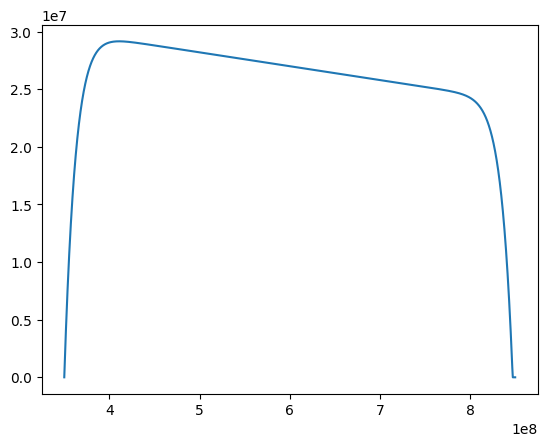

In [4]:
show_loop()

In [5]:
# Current KID model

def add_gaussian_noise(data, std_dev, mean=0):
    noise = np.random.normal(mean, std_dev, size=data.shape)
    noisy_data = data + noise
    return noisy_data
    

@numba.jit(nopython=True)
def cubic_root(x):
    """Compute cubic root of a number while maintaining its sign.
    
    x: (complex) The number.
    """
    
    third = 1./3.
    
    if x.real >= 0:
        return x**third
    else:
        return -(-x)**third
    
    
@numba.jit(nopython=True)
def cubicRealRoot(a, b, c):
    """Analytical closed-form solver for a single cubic equation.
    x^3 + a*x^2 + bx + c = 0
    Gives only one real root.
    
    a, b, c: (float) Cubic coeficients.
    """
    
    third = 1./3.
    a13 = a*third
    a2 = a13*a13
    f = third*b - a2
    g = a13 * (2*a2 - b) + c
    h = 0.25*g*g + f*f*f

    if f == g == h == 0:
        return -cubic_root(c)

    elif h.real <= 0:
        j = np.sqrt(-f)
        k = np.arccos(-0.5*g / (j*j*j))
        m = np.cos(third*k)
        return 2*j*m - a13

    else:
        sqrt_h = cmath.sqrt(h)
        S = cubic_root(-0.5*g + sqrt_h)
        U = cubic_root(-0.5*g - sqrt_h)
        S_plus_U = S + U
        return S_plus_U - a13
    
    
def xSolver(fi, Pi, f0, Es, Qr, Qc):
    """Solve for x, the detuning.
    
    fi: Frequency of bin.
    Pi: Input power in bin.
    f0, Es, Qr, Qc: See modelKid() decription.
    """
    
    from numpy.polynomial import polynomial
    
    x0 = (fi - f0)/f0
    a = 2*Qr**3*Pi/Qc/f0/Es
    # c3 = 1
    c2 = -x0
    c1 = 1/(4*Qr**2)
    c0 = -1/(4*Qr**2)*(a/Qr + x0)

    sol = cubicRealRoot(c2, c1, c0)
    
    return sol

def modelKid(f, P, f0, Es, Qr, Qc, yi, A):
    """Simple KID model.
    
    f:  Frequency in all bins, array.
    P:  Input power in all bins, array.
    f0: Resonance frequency of KID.
    Es: Scaling energy constant of KID.
    Qr: Overall loaded quality factor of KID.
    Qc: Coupling quality factor of KID.
    yi: Continuum asymmetry.
    A:  Amplitude scaling constant.
    """
    
    x = np.array([
        xSolver(f[i], P[i], f0, Es, Qr, Qc) 
        for i in range(len(f))
    ])
    
    yr = np.sqrt(1 - yi**2)
    y = (1 + yi*1j)
    
    # changing Qr based on power
    Qr =  (1 - 0.25*(1 -(0.1/P[1]))) * Qr
    
    S21 = 1 - A*(Qr/Qc)*y/(1+2j*Qr*x)
    
    
    
    #S21[S21<0] = 0
    
    return S21

In [6]:
def show_KID_at_power(p):
    freqs = np.linspace(5e8, 7e8, 100000)
    S21 = modelKid(f=freqs, P=np.ones_like(freqs)*p, f0=600e6, Es=0.1, Qr=10000, Qc=38000, yi=0, A=2)

    ax.plot(freqs, np.abs(S21), label=sym_test1(freqs, np.abs(S21))) 

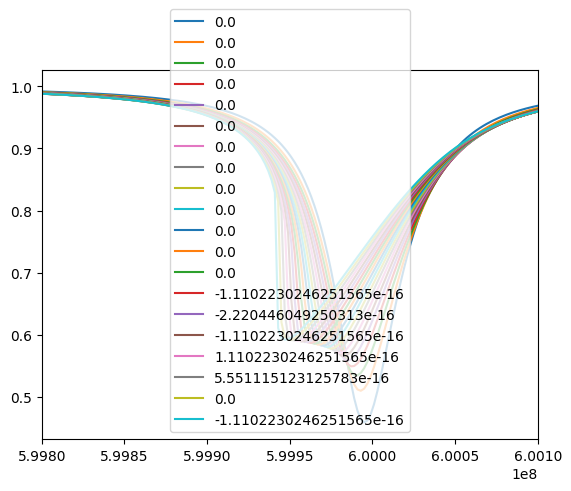

In [7]:
fig,ax = plt.subplots()

vals = np.linspace(0.09, 1, 20)
for i in range(len(vals)):
    show_KID_at_power(vals[i])

plt.xlim(599.8e6, 600.1e6) 
plt.legend()
plt.show()

In [8]:
test1 = np.linspace(1,10,20)

print(np.diff(test1))
print(np.gradient(test1))

[0.47368421 0.47368421 0.47368421 0.47368421 0.47368421 0.47368421
 0.47368421 0.47368421 0.47368421 0.47368421 0.47368421 0.47368421
 0.47368421 0.47368421 0.47368421 0.47368421 0.47368421 0.47368421
 0.47368421]
[0.47368421 0.47368421 0.47368421 0.47368421 0.47368421 0.47368421
 0.47368421 0.47368421 0.47368421 0.47368421 0.47368421 0.47368421
 0.47368421 0.47368421 0.47368421 0.47368421 0.47368421 0.47368421
 0.47368421 0.47368421]


In [9]:
# _toneFreqsAndAmpsFromSweepData
def _toneFreqsAndAmpsFromSweepData(f, Z, amps, N_steps, mod_amps=False):
    """
    Determine resonator tone frequencies and normalized amplitudes from sweep data.
    
    f:               (1D array of floats) Central frequency for each bin.
    Z:               (1D array of floats) Complex S21 values.
    amps:            (1D array of floats) Current normalized tone amplitudes.
    N_steps:         (int) Number of LO frequencies to divide each channel into.
    """

    #print(f.shape)
    
    y     = np.abs(Z)                    # magnitude of Z
    f_res = np.reshape(f, (-1, N_steps)) # split f by KID
    y_res = np.reshape(y, (-1, N_steps)) # split Zm by KID
    # _res vars are 2D arrays: one 1D array per resonator
    # print('###')
    # print(f_res.shape)
    # print(y_res.shape)

    
    # KID resonance frequencies
    i_res = np.argmin(y_res, axis=1)
    freqs = f_res[tuple([np.arange(0,len(i_res)), i_res])] # multi-dim. array indexing

    if mod_amps:
        # Power
        # np.gradient provides the slope at each point.
        # The asymmetry of the resonator shape in frequency space 
        # can be characterized by the sum of the max and min slopes.
        
        # y_grad = np.gradient(y_res, axis=1)         # slope at each point
        # a = np.max(y_grad, axis=1) + np.min(y_grad, axis=1)  # sum max and min slopes
        # a /= np.max(np.abs(y_grad), axis=1)         # normalize
        # amps_new = (1 + a)*amps 

        y_grad = np.gradient(y_res, axis=0) 
        a = np.max(y_grad, axis=0) + np.min(y_grad, axis=0)
        a /= np.max(np.abs(y_grad), axis=0)
        
        amps_new = (1 + a)*amps
    else:
        amps_new = amps

    return (freqs, amps_new)

In [10]:
def tone_fix(power):

    #tone comb
    freqs = np.linspace(5e8, 7e8, 500000)
    pows = np.ones_like(freqs)*power #0.05
    
    #sweep + KID
    _,S21 = modelLoopbackSweep(freqs=freqs, amp_max=3)
    S21 = S21 + (np.abs(modelKid(f=freqs, P=pows, f0=600e6, Es=0.1, Qr=10000, Qc=38000, yi=0, A=2)) - 1)

    
    #New comb
    f_new, a_new = _toneFreqsAndAmpsFromSweepData(freqs, S21, pows, 1, mod_amps=True)
    
    #Sweep + KID with new comb
    _,S21new = modelLoopbackSweep(freqs=f_new, amp_max=3)
    S21new = S21new + (np.abs(modelKid(f=f_new, P=a_new, f0=600e6, Es=0.1, Qr=10000, Qc=38000, yi=0, A=2)) -1)
    S21new = add_gaussian_noise(S21new, 0.1)

    #showing results
    plt.figure(1)
    plt.suptitle('Tone comb')
    ax1 = plt.subplot(211)
    plt.plot(freqs, pows, label='before')
    ax2 = plt.subplot(212)
    plt.plot(f_new, a_new, label='after')
    ax1.get_shared_x_axes().join(ax1, ax2)
    plt.xlim(5.995e8, 6.005e8)
    plt.legend()
    
    plt.figure(2)
    plt.suptitle('TSweeps')
    ax3 = plt.subplot(211)
    plt.plot(freqs, S21, label='before')
    ax4 = plt.subplot(212)
    plt.plot(f_new, S21new, label='after')
    ax3.get_shared_x_axes().join(ax3, ax4)
    ax3.get_shared_y_axes().join(ax3, ax4)
    plt.xlim(5.995e8, 6.005e8)
    plt.ylim(2,3)
    plt.legend()

    plt.show()

#tone_fix(0.05)

/tmp/ipykernel_2967/4137724951.py:27: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_x_axes().join(ax1, ax2)
/tmp/ipykernel_2967/4137724951.py:37: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_x_axes().join(ax3, ax4)
/tmp/ipykernel_2967/4137724951.py:38: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_y_axes().join(ax3, ax4)


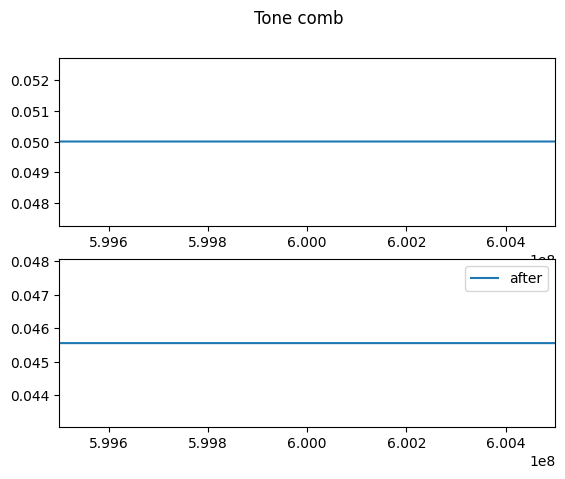

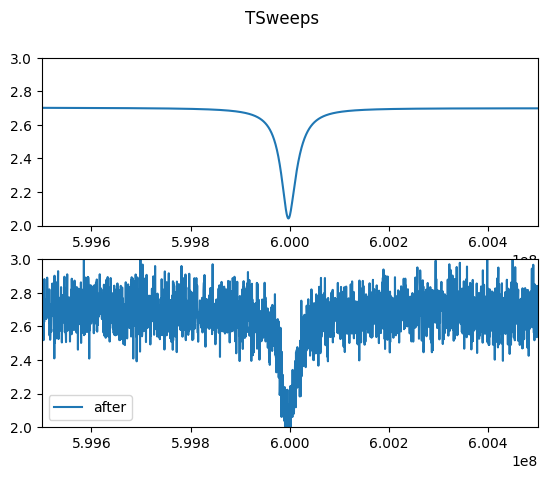

In [11]:
%matplotlib inline
plt.close()
tone_fix(0.05)

/tmp/ipykernel_2967/4137724951.py:27: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_x_axes().join(ax1, ax2)
/tmp/ipykernel_2967/4137724951.py:37: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_x_axes().join(ax3, ax4)
/tmp/ipykernel_2967/4137724951.py:38: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_y_axes().join(ax3, ax4)


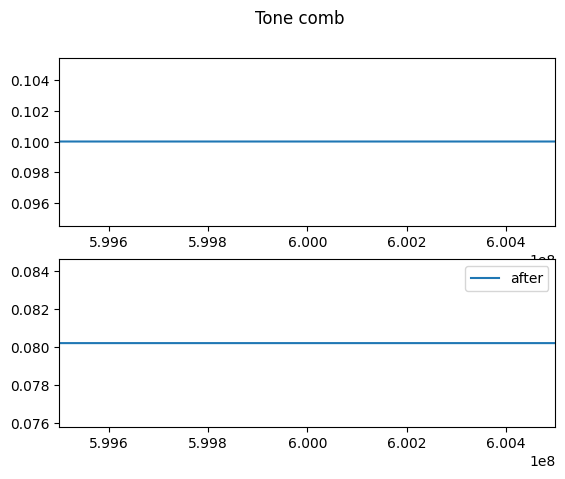

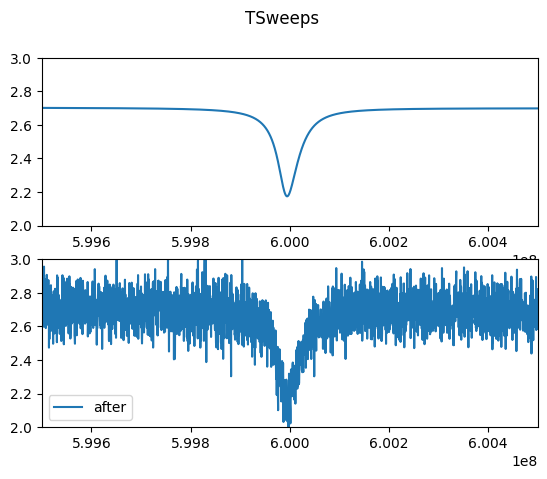

In [12]:
tone_fix(0.1)

/tmp/ipykernel_2967/4137724951.py:27: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_x_axes().join(ax1, ax2)
/tmp/ipykernel_2967/4137724951.py:37: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_x_axes().join(ax3, ax4)
/tmp/ipykernel_2967/4137724951.py:38: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_y_axes().join(ax3, ax4)


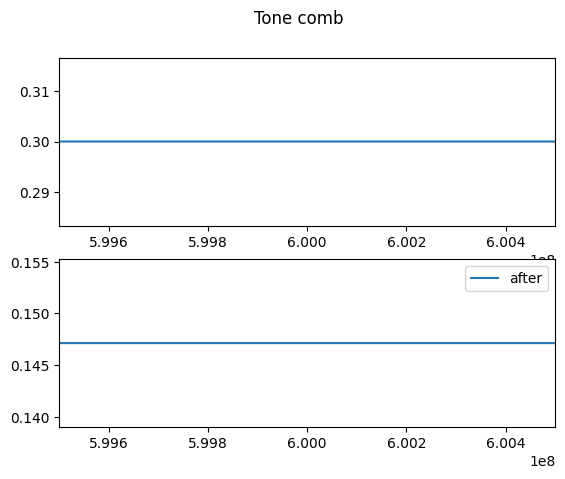

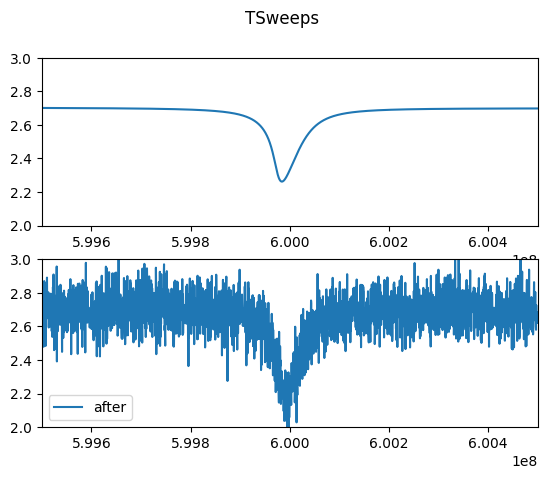

In [13]:
tone_fix(0.3)

/tmp/ipykernel_2967/4137724951.py:27: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_x_axes().join(ax1, ax2)
/tmp/ipykernel_2967/4137724951.py:37: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_x_axes().join(ax3, ax4)
/tmp/ipykernel_2967/4137724951.py:38: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_y_axes().join(ax3, ax4)


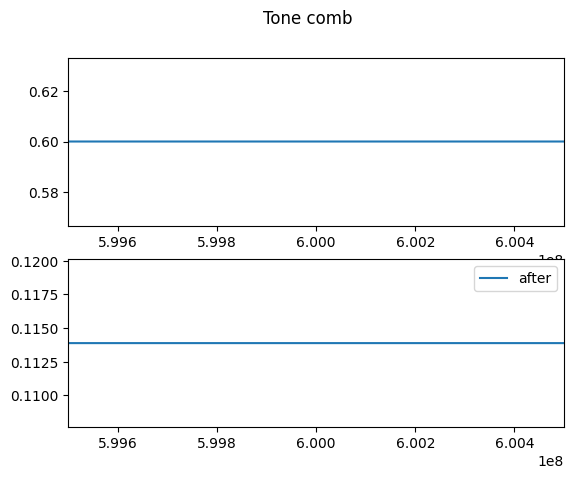

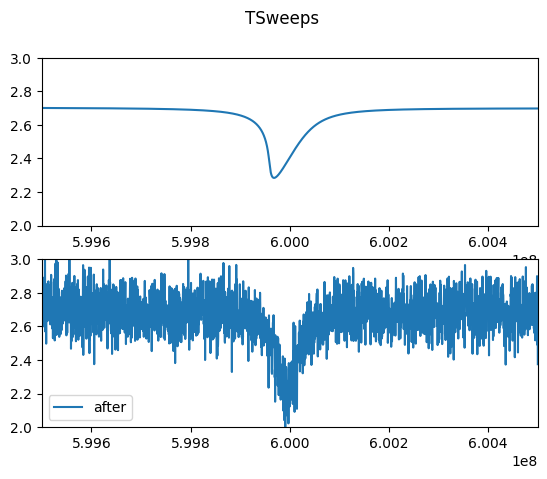

In [14]:
tone_fix(0.6)

/tmp/ipykernel_2967/4137724951.py:27: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_x_axes().join(ax1, ax2)
/tmp/ipykernel_2967/4137724951.py:37: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_x_axes().join(ax3, ax4)
/tmp/ipykernel_2967/4137724951.py:38: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_y_axes().join(ax3, ax4)


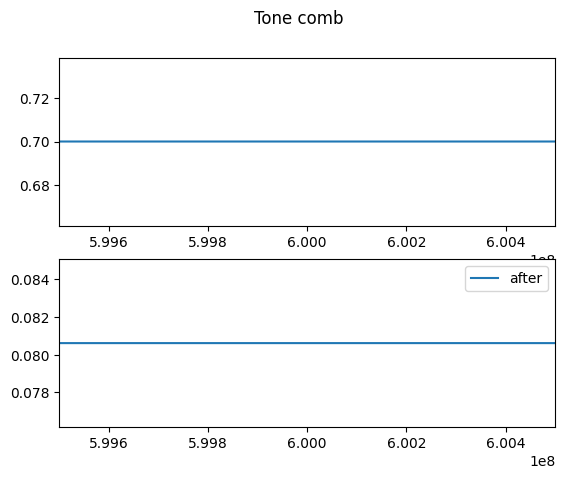

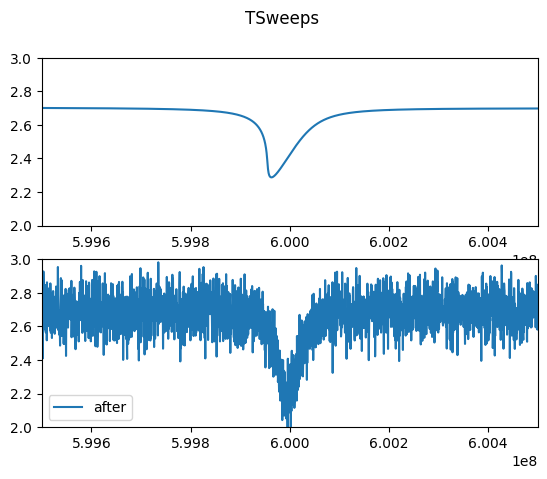

In [15]:
tone_fix(0.7)

/tmp/ipykernel_2967/4137724951.py:27: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_x_axes().join(ax1, ax2)
/tmp/ipykernel_2967/4137724951.py:37: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_x_axes().join(ax3, ax4)
/tmp/ipykernel_2967/4137724951.py:38: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_y_axes().join(ax3, ax4)


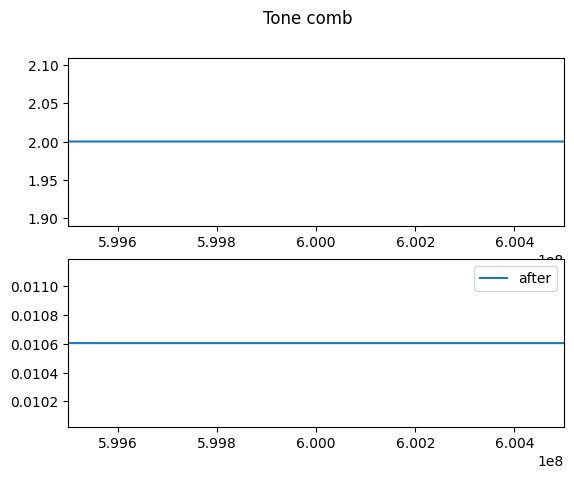

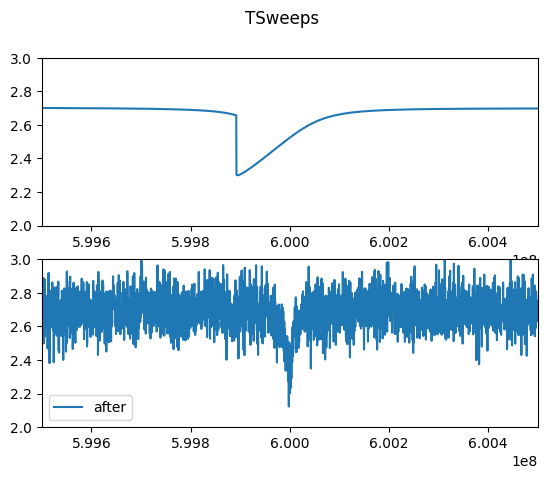

In [16]:
tone_fix(2)

/tmp/ipykernel_2967/4137724951.py:27: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_x_axes().join(ax1, ax2)
/tmp/ipykernel_2967/4137724951.py:37: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_x_axes().join(ax3, ax4)
/tmp/ipykernel_2967/4137724951.py:38: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_y_axes().join(ax3, ax4)


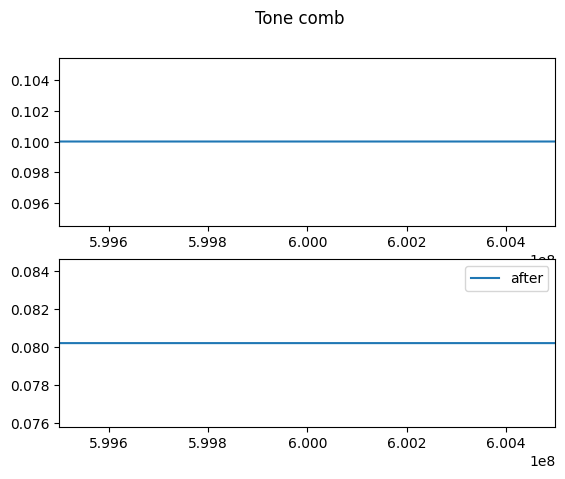

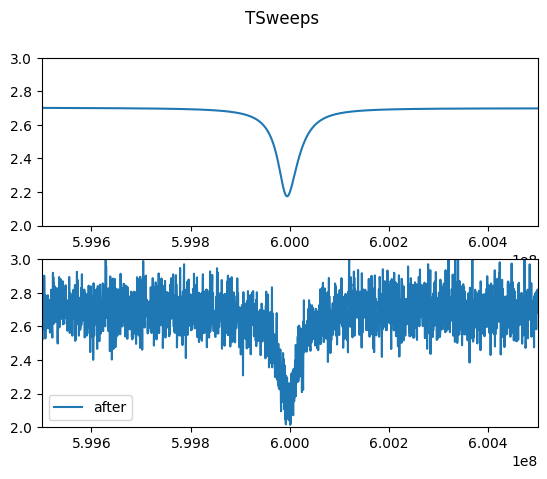

In [17]:
tone_fix(0.1)

/tmp/ipykernel_2967/4137724951.py:27: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_x_axes().join(ax1, ax2)
/tmp/ipykernel_2967/4137724951.py:37: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_x_axes().join(ax3, ax4)
/tmp/ipykernel_2967/4137724951.py:38: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_y_axes().join(ax3, ax4)


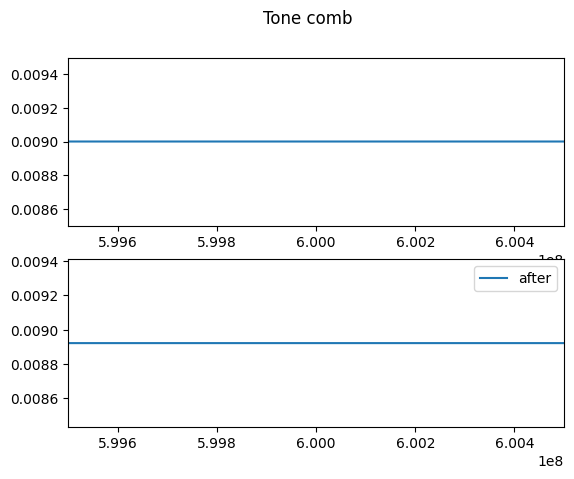

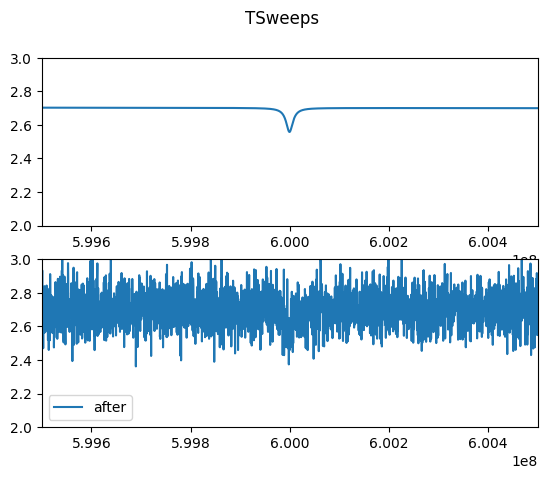

In [18]:
tone_fix(0.009)

/tmp/ipykernel_2967/366104824.py:41: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_x_axes().join(ax3, ax4)
/tmp/ipykernel_2967/366104824.py:42: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_y_axes().join(ax3, ax4)


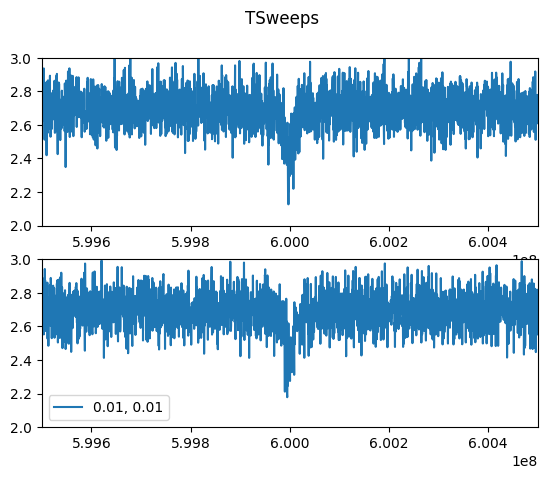

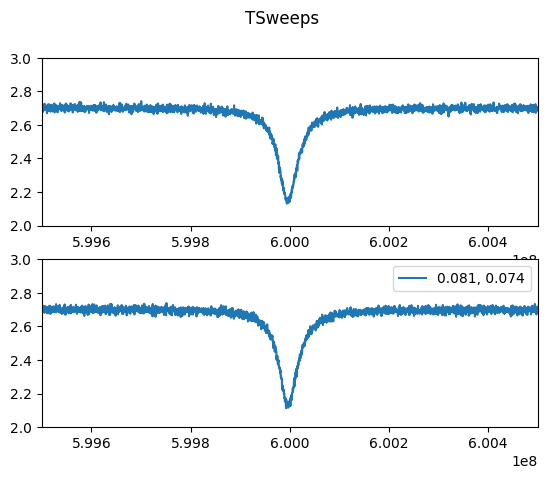

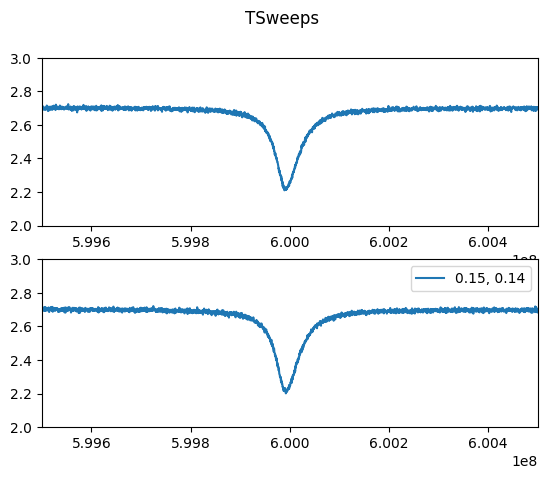

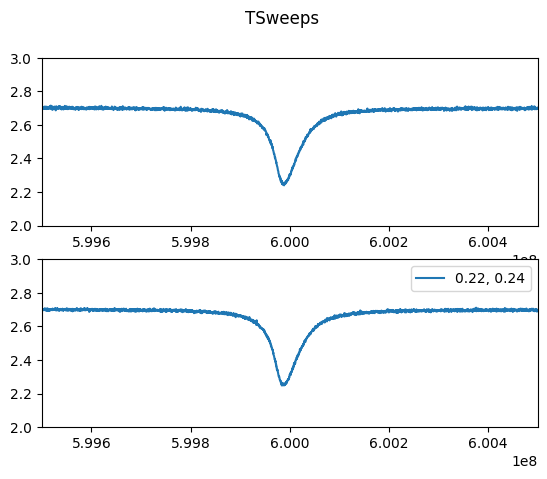

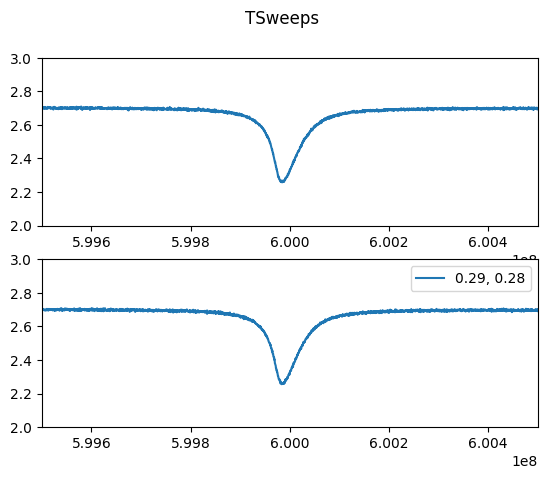

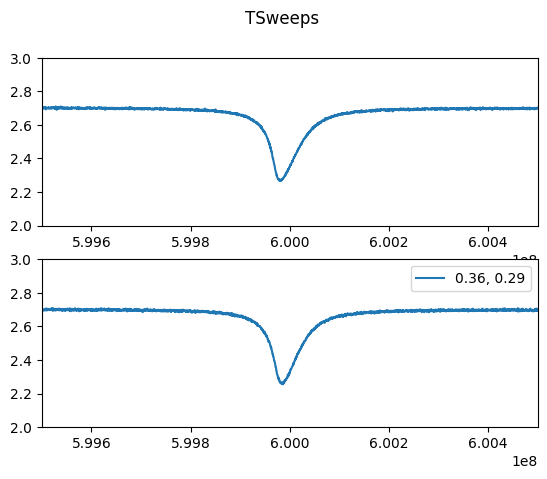

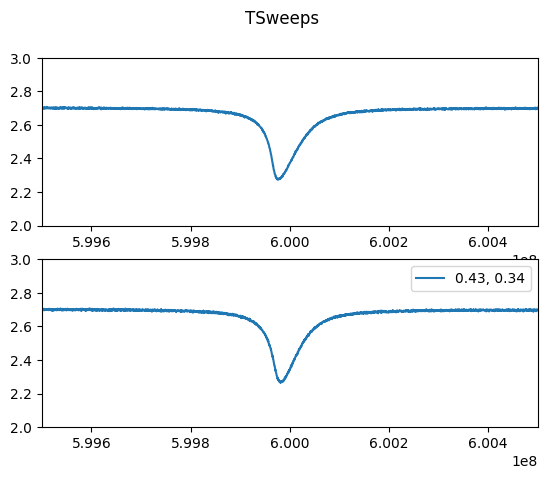

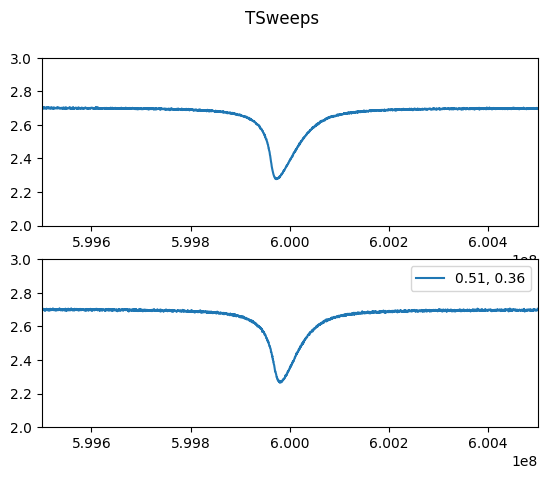

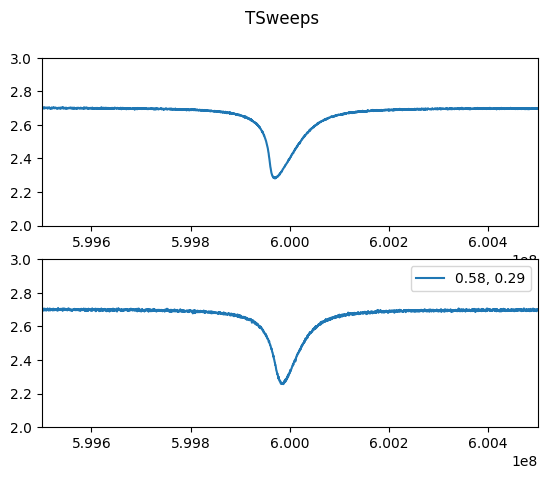

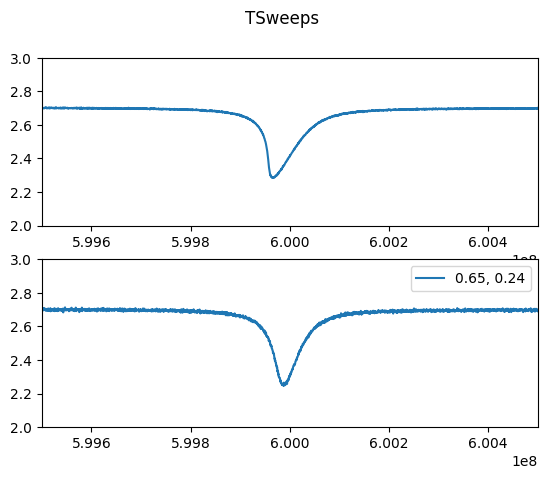

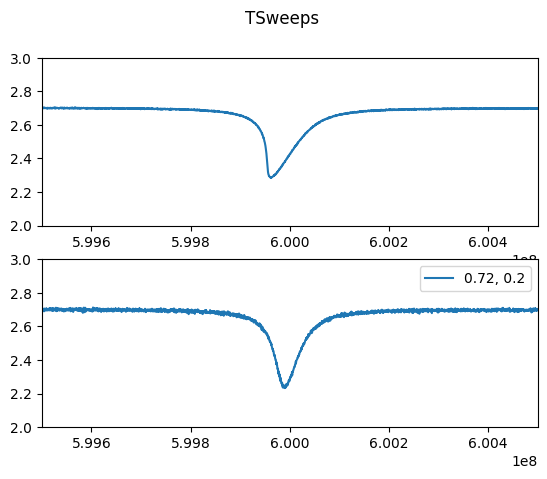

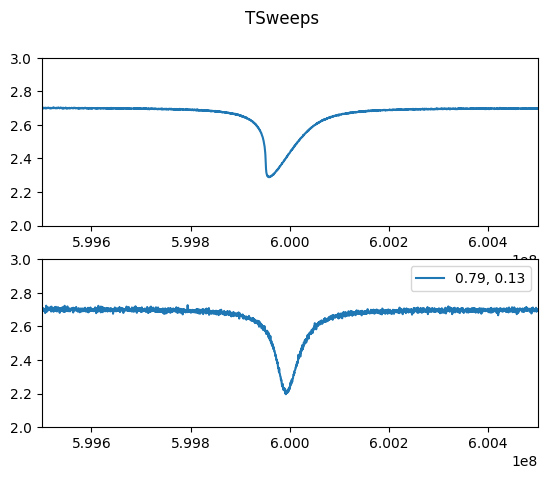

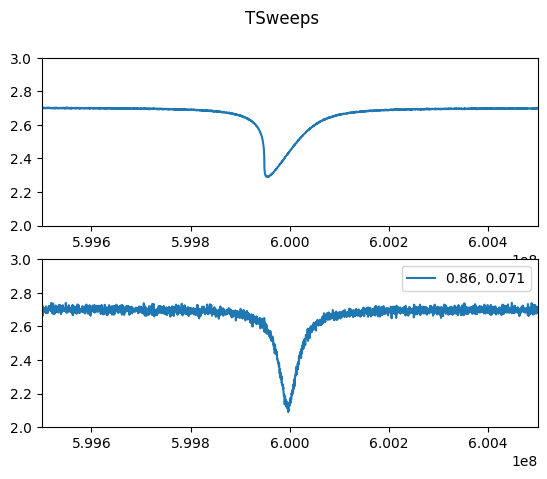

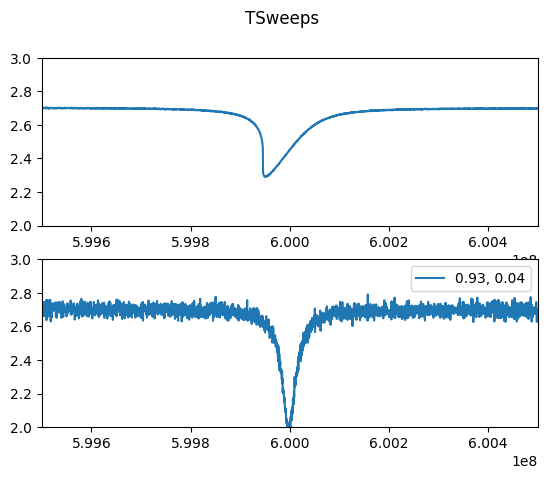

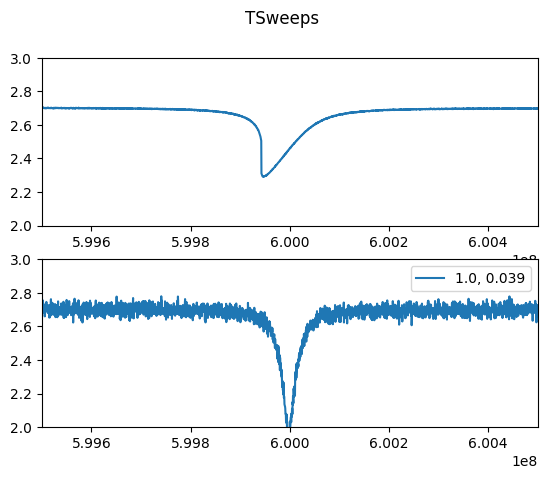

In [21]:
def tones():
        
    def tone_fix(power):
    
        #tone comb
        freqs = np.linspace(5e8, 7e8, 500000)
        pows = np.ones_like(freqs)*power #0.05
        
        #sweep + KID
        _,S21 = modelLoopbackSweep(freqs=freqs, amp_max=3)
        S21 = S21 + (np.abs(modelKid(f=freqs, P=pows, f0=600e6, Es=0.1, Qr=10000, Qc=38000, yi=0, A=2)) - 1)
        S21 = add_gaussian_noise(S21, 0.001*(1/power))
    
        
        #New comb
        f_new, a_new = _toneFreqsAndAmpsFromSweepData(freqs, S21, pows, 1, mod_amps=True)
        
        #Sweep + KID with new comb
        _,S21new = modelLoopbackSweep(freqs=f_new, amp_max=3)
        S21new = S21new + (np.abs(modelKid(f=f_new, P=a_new, f0=600e6, Es=0.1, Qr=10000, Qc=38000, yi=0, A=2)) -1)
        S21new = add_gaussian_noise(S21new, 0.001*(1/a_new[0]))
    
        #showing results
        # plt.figure(1)
        # plt.suptitle('Tone comb')
        # ax1 = plt.subplot(211)
        # plt.plot(freqs, pows, label='before')
        # ax2 = plt.subplot(212)
        # plt.plot(f_new, a_new, label='after')
        # ax1.get_shared_x_axes().join(ax1, ax2)
        # plt.xlim(5.995e8, 6.005e8)
        # plt.legend()
        
        #plt.figure(3, figsize=(5,2))
        plt.figure(4)
        plt.suptitle('TSweeps')
        ax3 = plt.subplot(211)
        plt.plot(freqs, S21, label='before')
        ax4 = plt.subplot(212)
        plt.plot(f_new, S21new, label=f"{power:.2}, {a_new[0]:.2}")
        ax3.get_shared_x_axes().join(ax3, ax4)
        ax3.get_shared_y_axes().join(ax3, ax4)
        plt.xlim(5.995e8, 6.005e8)
        plt.ylim(2,3)
        plt.legend()
    
        plt.show()

    for i in np.linspace(0.01,1,15):
        tone_fix(i)
        
        
tones()

/tmp/ipykernel_2967/1517536636.py:40: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_x_axes().join(ax3, ax4)
/tmp/ipykernel_2967/1517536636.py:41: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_y_axes().join(ax3, ax4)


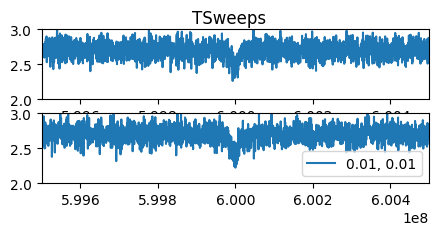

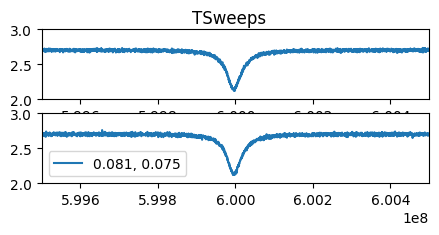

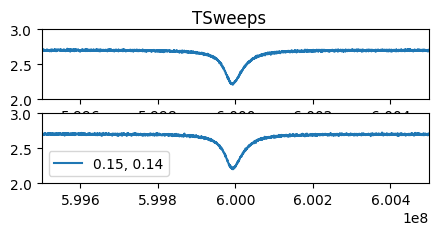

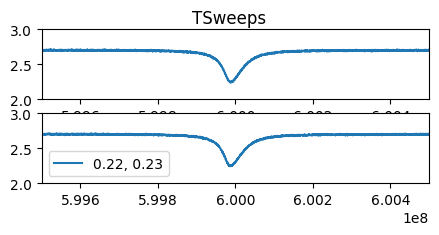

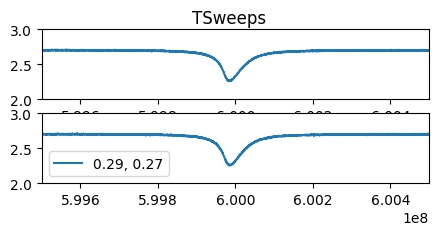

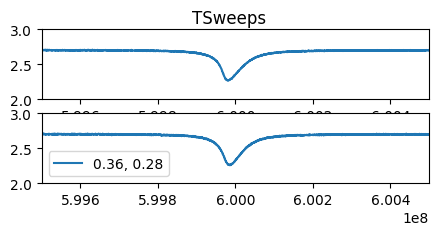

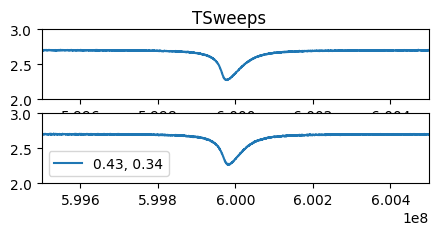

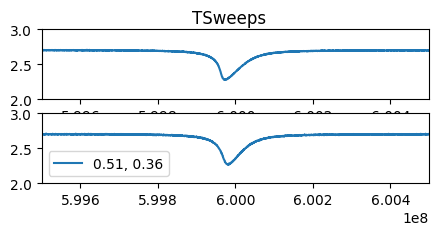

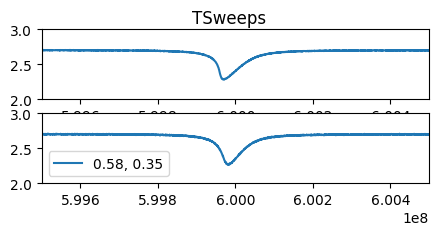

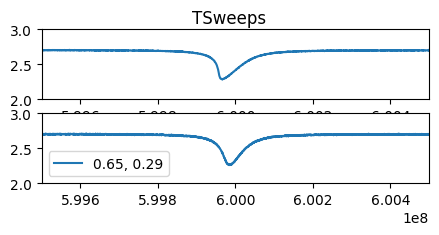

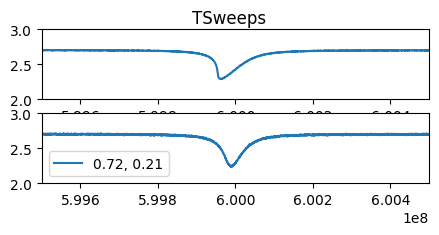

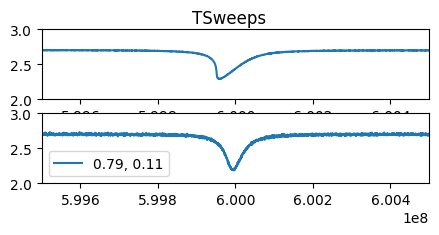

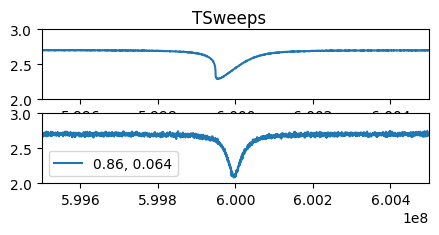

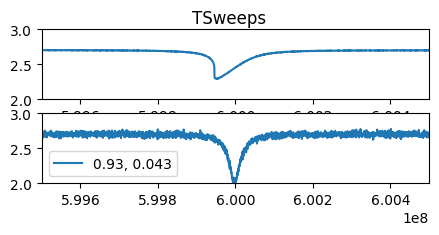

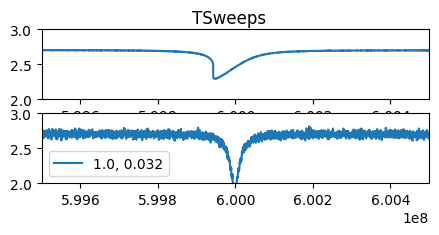

In [22]:
def tones():
        
    def tone_fix(power):
    
        #tone comb
        freqs = np.linspace(5e8, 7e8, 500000)
        pows = np.ones_like(freqs)*power #0.05
        
        #sweep + KID
        _,S21 = modelLoopbackSweep(freqs=freqs, amp_max=3)
        S21 = S21 + (np.abs(modelKid(f=freqs, P=pows, f0=600e6, Es=0.1, Qr=10000, Qc=38000, yi=0, A=2)) - 1)
        S21 = add_gaussian_noise(S21, 0.001*(1/power))
    
        
        #New comb
        f_new, a_new = _toneFreqsAndAmpsFromSweepData(freqs, S21, pows, 1, mod_amps=True)
        
        #Sweep + KID with new comb
        _,S21new = modelLoopbackSweep(freqs=f_new, amp_max=3)
        S21new = S21new + (np.abs(modelKid(f=f_new, P=a_new, f0=600e6, Es=0.1, Qr=10000, Qc=38000, yi=0, A=2)) -1)
        S21new = add_gaussian_noise(S21new, 0.001*(1/a_new[0]))
    
        #showing results
        # plt.figure(1)
        # plt.suptitle('Tone comb')
        # ax1 = plt.subplot(211)
        # plt.plot(freqs, pows, label='before')
        # ax2 = plt.subplot(212)
        # plt.plot(f_new, a_new, label='after')
        # ax1.get_shared_x_axes().join(ax1, ax2)
        # plt.xlim(5.995e8, 6.005e8)
        # plt.legend()
        
        plt.figure(3, figsize=(5,2))
        plt.suptitle('TSweeps')
        ax3 = plt.subplot(211)
        plt.plot(freqs, S21, label='before')
        ax4 = plt.subplot(212)
        plt.plot(f_new, S21new, label=f"{power:.2}, {a_new[0]:.2}")
        ax3.get_shared_x_axes().join(ax3, ax4)
        ax3.get_shared_y_axes().join(ax3, ax4)
        plt.xlim(5.995e8, 6.005e8)
        plt.ylim(2,3)
        plt.legend()
    
        plt.show()

    for i in np.linspace(0.01,1,15):
        tone_fix(i)
        
        
tones()

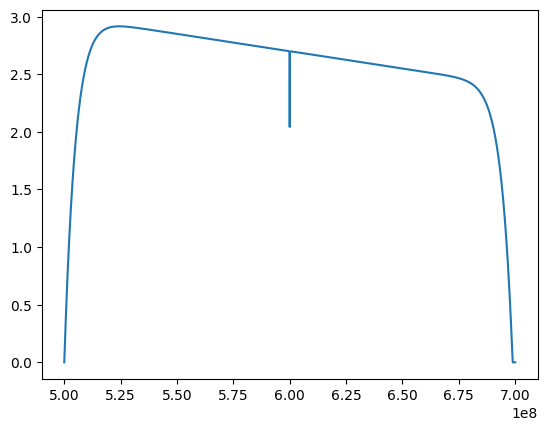

In [24]:
#tone comb
freqs = np.linspace(5e8, 7e8, 500000)
pows = np.ones_like(freqs)*0.05 #0.05

#sweep + KID
_,S21 = modelLoopbackSweep(freqs=freqs, amp_max=3)
S21 = S21 + (np.abs(modelKid(f=freqs, P=pows, f0=600e6, Es=0.1, Qr=10000, Qc=38000, yi=0, A=2)) - 1)

plt.plot(freqs, S21)